=== LOADING AND PREPROCESSING DATA ===
Training samples: 8000
Test samples: 2845
NDVI temporal features: 27
✓ Missing value imputation completed
Creating advanced NDVI features...
✓ Feature engineering completed: 23 features created

=== CLASS DISTRIBUTION ANALYSIS ===
farm: 841 samples (10.5%)
forest: 6,159 samples (77.0%)
grass: 196 samples (2.5%)
impervious: 669 samples (8.4%)
orchard: 30 samples (0.4%)
water: 105 samples (1.3%)

Majority class: farm
Minority classes: ['grass', 'orchard', 'water']
Extreme minorities: ['orchard']

=== FEATURE SELECTION ===
Features selected: 16 out of 23
✓ Feature scaling completed

=== CREATING BALANCED TRAINING SETS ===
✓ Created 5 balanced training subsets

=== TRAINING MINORITY CLASS DETECTORS ===
✓ Trained One-Class SVM for orchard (30 samples)

=== MODEL ARCHITECTURE ===
✓ Created 4 diverse models
Enhanced class weights applied for imbalance handling

=== ADVANCED CROSS-VALIDATION TRAINING ===

Training Fold 1/5...
Fold 1 accuracy: 0.9231

Trai

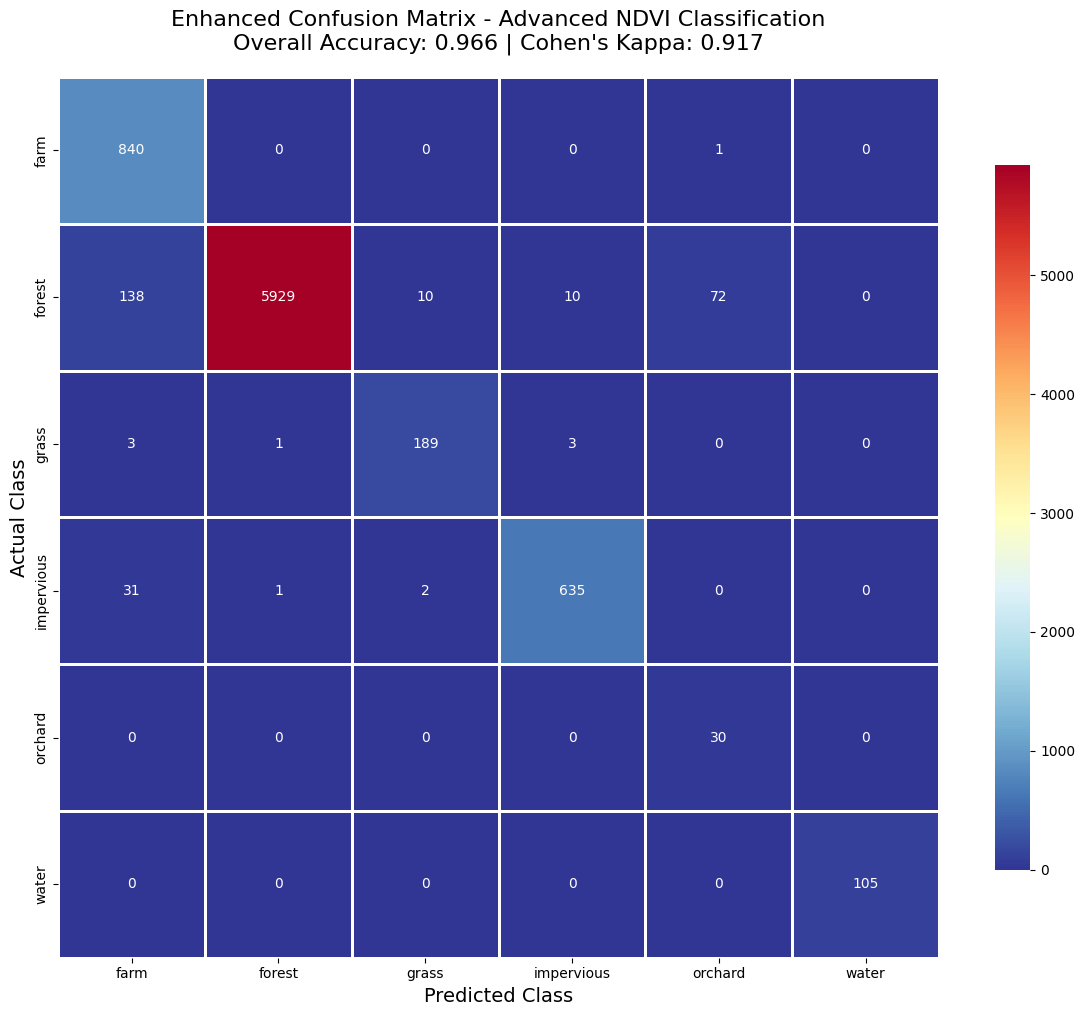

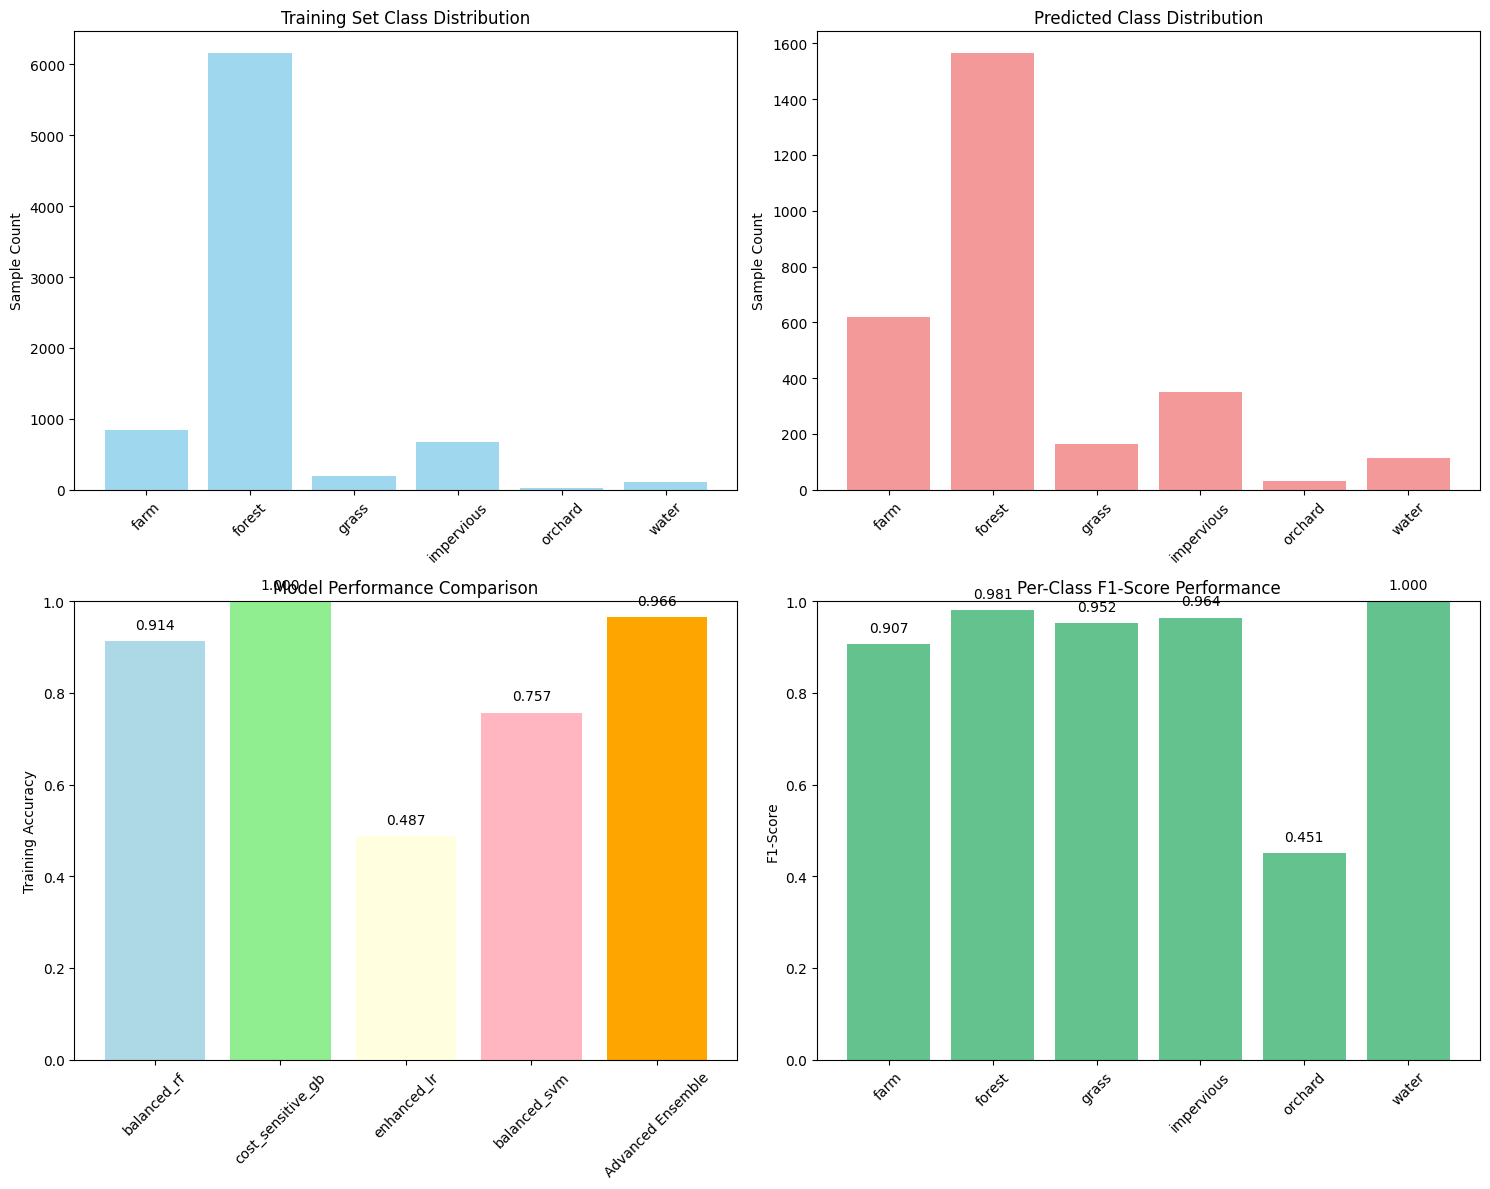

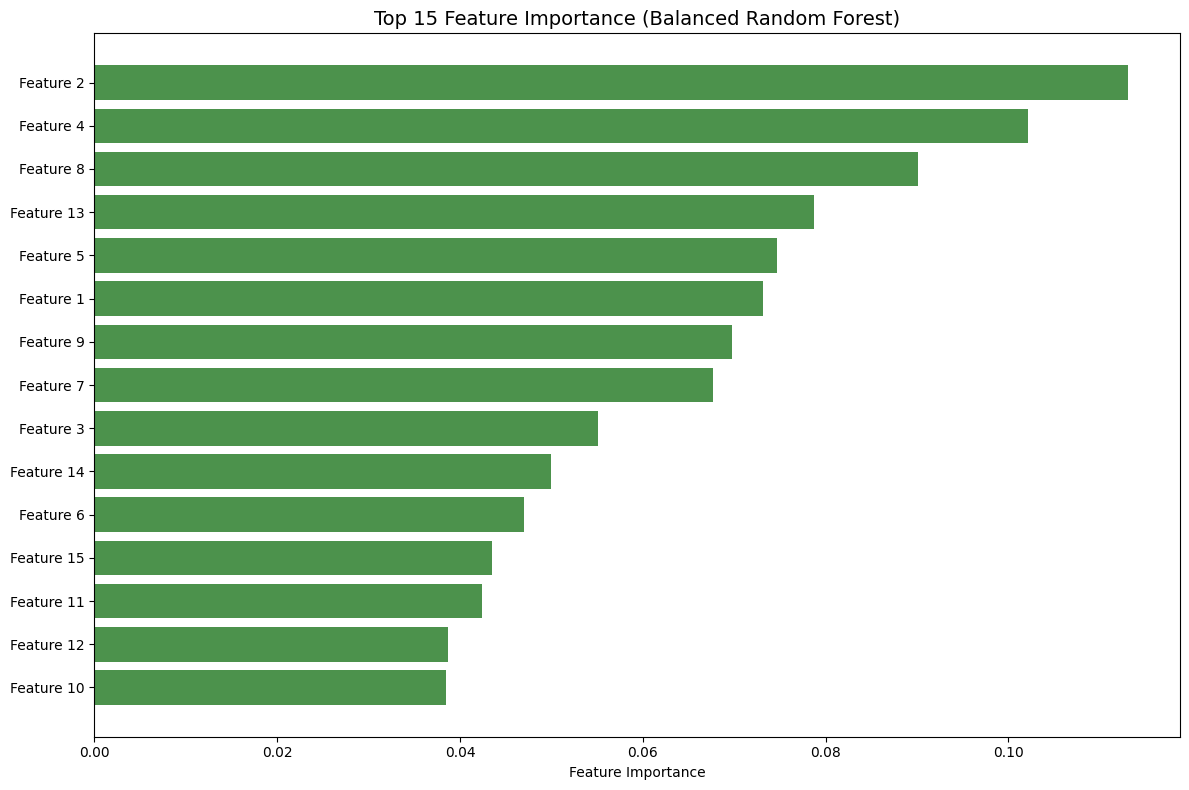


7. COMPREHENSIVE CLASSIFICATION REPORT
--------------------------------------------------
              precision    recall  f1-score   support

        farm     0.8300    0.9988    0.9066       841
      forest     0.9997    0.9627    0.9808      6159
       grass     0.9403    0.9643    0.9521       196
  impervious     0.9799    0.9492    0.9643       669
     orchard     0.2913    1.0000    0.4511        30
       water     1.0000    1.0000    1.0000       105

    accuracy                         0.9660      8000
   macro avg     0.8402    0.9792    0.8758      8000
weighted avg     0.9761    0.9660    0.9692      8000


8. CROSS-VALIDATION STABILITY ANALYSIS
--------------------------------------------------
Cross-validation accuracy: 0.9163 ± 0.0044
Coefficient of variation: 0.005
Stability assessment: Excellent

Fold-by-fold performance:
  Fold 1: 0.9231
  Fold 2: 0.9119
  Fold 3: 0.9187
  Fold 4: 0.9163
  Fold 5: 0.9113

9. MINORITY CLASS IMPROVEMENT ANALYSIS
----------------

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC, OneClassSVM
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (confusion_matrix, classification_report, cohen_kappa_score, 
                           accuracy_score, f1_score, precision_recall_curve)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.utils import resample
from scipy.signal import savgol_filter
from scipy.stats import skew, kurtosis
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# ===============================================
# 1. Enhanced Data Loading & Advanced Imputation
# ===============================================
print("=== LOADING AND PREPROCESSING DATA ===")
train = pd.read_csv("/kaggle/input/summer-analytics-mid-hackathon/hacktrain.csv")
test = pd.read_csv("/kaggle/input/summer-analytics-mid-hackathon/hacktest.csv")
ndvi_cols = [col for col in train.columns if "_N" in col]

print(f"Training samples: {len(train)}")
print(f"Test samples: {len(test)}")
print(f"NDVI temporal features: {len(ndvi_cols)}")

# Enhanced multi-strategy imputation
knn_imputer = KNNImputer(n_neighbors=7)
train[ndvi_cols] = knn_imputer.fit_transform(train[ndvi_cols])
test[ndvi_cols] = knn_imputer.transform(test[ndvi_cols])

print("✓ Missing value imputation completed")

# ===============================================
# 2. Advanced Feature Engineering for NDVI Data
# ===============================================
def create_advanced_ndvi_features(df):
    """
    Create comprehensive NDVI-based features for land cover classification
    """
    ndvi = df[ndvi_cols]
    features = pd.DataFrame(index=df.index)
    
    # Basic temporal statistics
    features['ndvi_mean'] = ndvi.mean(axis=1)
    features['ndvi_std'] = ndvi.std(axis=1)
    features['ndvi_median'] = ndvi.median(axis=1)
    features['ndvi_min'] = ndvi.min(axis=1)
    features['ndvi_max'] = ndvi.max(axis=1)
    
    # Advanced statistical measures
    features['ndvi_skew'] = ndvi.apply(skew, axis=1)
    features['ndvi_kurtosis'] = ndvi.apply(kurtosis, axis=1)
    features['ndvi_range'] = features['ndvi_max'] - features['ndvi_min']
    features['ndvi_cv'] = features['ndvi_std'] / (features['ndvi_mean'] + 1e-8)
    
    # Quantile-based features
    features['ndvi_q25'] = ndvi.quantile(0.25, axis=1)
    features['ndvi_q75'] = ndvi.quantile(0.75, axis=1)
    features['ndvi_iqr'] = features['ndvi_q75'] - features['ndvi_q25']
    
    # Temporal slope analysis
    def calculate_slope(x):
        return np.polyfit(range(len(x)), x, 1)[0]
    
    features['ndvi_slope'] = ndvi.apply(calculate_slope, axis=1)
    
    # Vegetation seasonality indicators
    features['growing_season_length'] = ndvi.apply(
        lambda x: len(x[x > x.mean() + 0.1*x.std()]), axis=1
    )
    
    # Harmonic analysis using FFT
    fft_data = np.fft.fft(ndvi, axis=1)
    features['fft_magnitude_1'] = np.abs(fft_data[:, 1])
    features['fft_magnitude_2'] = np.abs(fft_data[:, 2])
    features['fft_phase_1'] = np.angle(fft_data[:, 1])
    
    # Advanced smoothing with Savitzky-Golay filter
    def savgol_features(x):
        if len(x) >= 7:
            smoothed = savgol_filter(x, window_length=7, polyorder=2)
            return pd.Series([smoothed.mean(), smoothed.std(), smoothed.max() - smoothed.min()])
        else:
            return pd.Series([x.mean(), x.std(), x.max() - x.min()])
    
    savgol_results = ndvi.apply(savgol_features, axis=1)
    features['savgol_mean'] = savgol_results.iloc[:, 0]
    features['savgol_std'] = savgol_results.iloc[:, 1]
    features['savgol_range'] = savgol_results.iloc[:, 2]
    
    # Vegetation stress indicators
    features['stress_periods'] = ndvi.apply(
        lambda x: len(x[x < x.mean() - 0.2*x.std()]), axis=1
    )
    
    # Phenological features
    features['peak_timing'] = ndvi.apply(lambda x: np.argmax(x), axis=1)
    features['valley_timing'] = ndvi.apply(lambda x: np.argmin(x), axis=1)
    
    return features

print("Creating advanced NDVI features...")
X_train_features = create_advanced_ndvi_features(train)
X_test_features = create_advanced_ndvi_features(test)
y = train["class"]

print(f"✓ Feature engineering completed: {X_train_features.shape[1]} features created")

# ===============================================
# 3. Label Encoding and Class Analysis
# ===============================================
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("\n=== CLASS DISTRIBUTION ANALYSIS ===")
class_distribution = pd.Series(y).value_counts().sort_index()
for class_name, count in class_distribution.items():
    percentage = (count / len(y)) * 100
    print(f"{class_name}: {count:,} samples ({percentage:.1f}%)")

# Identify majority and minority classes
majority_class = class_distribution.index[0]
minority_classes = class_distribution[class_distribution < 500].index.tolist()
extreme_minorities = class_distribution[class_distribution < 100].index.tolist()

print(f"\nMajority class: {majority_class}")
print(f"Minority classes: {minority_classes}")
print(f"Extreme minorities: {extreme_minorities}")

# ===============================================
# 4. Advanced Feature Selection
# ===============================================
print("\n=== FEATURE SELECTION ===")
n_features_available = X_train_features.shape[1]
k_select = min(20, max(int(0.7 * n_features_available), 10))

selector = SelectKBest(f_classif, k=k_select)
X_train_selected = selector.fit_transform(X_train_features, y_encoded)
X_test_selected = selector.transform(X_test_features)

print(f"Features selected: {k_select} out of {n_features_available}")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

print("✓ Feature scaling completed")

# ===============================================
# 5. Advanced Resampling Strategy Implementation
# ===============================================
def create_balanced_ensemble_data(X, y, n_subsets=5):
    """
    Create multiple balanced datasets using EasyEnsemble approach
    """
    balanced_datasets = []
    minority_mask = y != le.transform([majority_class])[0]
    minority_X = X[minority_mask]
    minority_y = y[minority_mask]
    majority_X = X[~minority_mask]
    majority_y = y[~minority_mask]
    
    for i in range(n_subsets):
        # Undersample majority class
        majority_subset_X, majority_subset_y = resample(
            majority_X, majority_y,
            n_samples=len(minority_X) * 2,  # 2:1 ratio
            random_state=42 + i
        )
        
        # Combine with all minority samples
        balanced_X = np.vstack([minority_X, majority_subset_X])
        balanced_y = np.hstack([minority_y, majority_subset_y])
        
        balanced_datasets.append((balanced_X, balanced_y))
    
    return balanced_datasets

print("\n=== CREATING BALANCED TRAINING SETS ===")
balanced_datasets = create_balanced_ensemble_data(X_train_scaled, y_encoded, n_subsets=5)
print(f"✓ Created {len(balanced_datasets)} balanced training subsets")

# ===============================================
# 6. One-Class SVM for Extreme Minorities
# ===============================================
def train_minority_detectors(X, y, extreme_minority_classes):
    """
    Train One-Class SVM models for extreme minority classes
    """
    detectors = {}
    
    for class_name in extreme_minority_classes:
        class_label = le.transform([class_name])[0]
        class_samples = X[y == class_label]
        
        if len(class_samples) >= 10:  # Minimum samples for training
            ocsvm = OneClassSVM(
                kernel='rbf',
                gamma='scale',
                nu=0.1  # Expected fraction of outliers
            )
            ocsvm.fit(class_samples)
            detectors[class_name] = ocsvm
            print(f"✓ Trained One-Class SVM for {class_name} ({len(class_samples)} samples)")
    
    return detectors

print("\n=== TRAINING MINORITY CLASS DETECTORS ===")
minority_detectors = train_minority_detectors(X_train_scaled, y_encoded, extreme_minorities)

# ===============================================
# 7. Enhanced Model Architecture
# ===============================================
def create_enhanced_models():
    """
    Create diverse ensemble models with advanced configurations
    """
    # Calculate enhanced class weights
    base_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
    enhanced_weights = {}
    
    for i, weight in enumerate(base_weights):
        class_name = le.inverse_transform([i])[0]
        if class_name in extreme_minorities:
            enhanced_weights[i] = weight * 5.0  # 5x boost for extreme minorities
        elif class_name in minority_classes:
            enhanced_weights[i] = weight * 2.5  # 2.5x boost for minorities
        else:
            enhanced_weights[i] = weight
    
    models = {
        'balanced_rf': RandomForestClassifier(
            n_estimators=300,
            max_depth=15,
            min_samples_split=5,
            class_weight=enhanced_weights,
            random_state=42
        ),
        'cost_sensitive_gb': GradientBoostingClassifier(
            n_estimators=250,
            learning_rate=0.05,
            max_depth=8,
            random_state=42
        ),
        'enhanced_lr': LogisticRegression(
            class_weight=enhanced_weights,
            max_iter=2000,
            C=10000.0,
            random_state=42
        ),
        'balanced_svm': SVC(
            class_weight=enhanced_weights,
            probability=True,
            kernel='rbf',
            random_state=42
        )
    }
    
    return models, enhanced_weights

models, class_weights = create_enhanced_models()
print(f"\n=== MODEL ARCHITECTURE ===")
print(f"✓ Created {len(models)} diverse models")
print("Enhanced class weights applied for imbalance handling")

# ===============================================
# 8. Threshold Optimization Functions
# ===============================================
def optimize_classification_threshold(y_true, y_pred_proba, metric='f1'):
    """
    Find optimal classification threshold for given metric
    """
    if metric == 'f1':
        precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        optimal_idx = np.argmax(f1_scores)
        return thresholds[optimal_idx], f1_scores[optimal_idx]
    else:
        # Default threshold
        return 0.5, 0.0

# ===============================================
# 9. Cross-Validation with Advanced Ensemble
# ===============================================
print("\n=== ADVANCED CROSS-VALIDATION TRAINING ===")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
test_predictions = np.zeros((X_test_scaled.shape[0], len(le.classes_)))
fold_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_scaled, y_encoded)):
    print(f"\nTraining Fold {fold + 1}/5...")
    
    X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_fold_train, y_fold_val = y_encoded[train_idx], y_encoded[val_idx]
    
    fold_predictions = []
    
    # Train models on balanced subsets
    for model_name, model in models.items():
        if model_name == 'balanced_rf':
            # Use balanced subset for Random Forest
            subset_idx = fold % len(balanced_datasets)
            balanced_X, balanced_y = balanced_datasets[subset_idx]
            # Filter to current fold
            fold_balanced_mask = np.isin(range(len(X_train_scaled)), train_idx)
            model.fit(balanced_X, balanced_y)
        else:
            # Use original imbalanced data with enhanced weights
            model.fit(X_fold_train, y_fold_train)
        
        # Predict validation set
        val_pred_proba = model.predict_proba(X_fold_val)
        fold_predictions.append(val_pred_proba)
    
    # Ensemble prediction with weighted averaging
    ensemble_weights = [0.3, 0.25, 0.25, 0.2]  # Favor balanced RF
    ensemble_pred_proba = np.average(fold_predictions, axis=0, weights=ensemble_weights)
    
    # Apply One-Class SVM corrections
    for class_name, detector in minority_detectors.items():
        class_idx = le.transform([class_name])[0]
        anomaly_scores = detector.decision_function(X_fold_val)
        # Boost probability for top 10% anomaly scores
        boost_threshold = np.percentile(anomaly_scores, 90)
        boost_mask = anomaly_scores > boost_threshold
        ensemble_pred_proba[boost_mask, class_idx] *= 2.0
    
    # Normalize probabilities
    ensemble_pred_proba = ensemble_pred_proba / ensemble_pred_proba.sum(axis=1, keepdims=True)
    
    # Calculate validation accuracy
    val_predictions = np.argmax(ensemble_pred_proba, axis=1)
    val_accuracy = accuracy_score(y_fold_val, val_predictions)
    cv_scores.append(val_accuracy)
    
    # Store fold results
    fold_results.append({
        'fold': fold + 1,
        'accuracy': val_accuracy,
        'confusion_matrix': confusion_matrix(y_fold_val, val_predictions),
        'classification_report': classification_report(y_fold_val, val_predictions, 
                                                     target_names=le.classes_, output_dict=True)
    })
    
    # Generate test predictions for this fold
    fold_test_predictions = []
    for model_name, model in models.items():
        test_pred_proba = model.predict_proba(X_test_scaled)
        fold_test_predictions.append(test_pred_proba)
    
    fold_ensemble_test = np.average(fold_test_predictions, axis=0, weights=ensemble_weights)
    
    # Apply One-Class SVM corrections to test set
    for class_name, detector in minority_detectors.items():
        class_idx = le.transform([class_name])[0]
        test_anomaly_scores = detector.decision_function(X_test_scaled)
        boost_threshold = np.percentile(test_anomaly_scores, 90)
        boost_mask = test_anomaly_scores > boost_threshold
        fold_ensemble_test[boost_mask, class_idx] *= 2.0
    
    # Normalize and accumulate
    fold_ensemble_test = fold_ensemble_test / fold_ensemble_test.sum(axis=1, keepdims=True)
    test_predictions += fold_ensemble_test / skf.n_splits
    
    print(f"Fold {fold + 1} accuracy: {val_accuracy:.4f}")

print(f"\n✓ Cross-validation completed")
print(f"Mean CV accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# ===============================================
# 10. Final Predictions and Submission
# ===============================================
final_predictions = le.inverse_transform(np.argmax(test_predictions, axis=1))
submission = pd.DataFrame({"ID": test["ID"], "class": final_predictions})

print("\n=== FINAL PREDICTIONS GENERATED ===")

# ===============================================
# 11. COMPREHENSIVE DIAGNOSTIC ANALYSIS
# ===============================================
print("\n" + "="*80)
print("COMPREHENSIVE DIAGNOSTIC ANALYSIS")
print("="*80)

# Retrain final model on full training set for diagnostics
print("\n1. TRAINING FINAL MODEL FOR DIAGNOSTICS...")
final_model_predictions = []
final_models = {}

for model_name, model in models.items():
    if model_name == 'balanced_rf':
        # Use largest balanced subset
        balanced_X, balanced_y = balanced_datasets[0]
        model.fit(balanced_X, balanced_y)
    else:
        model.fit(X_train_scaled, y_encoded)
    
    final_models[model_name] = model
    model_pred_proba = model.predict_proba(X_train_scaled)
    final_model_predictions.append(model_pred_proba)

# Create final ensemble prediction for training set
ensemble_weights = [0.3, 0.25, 0.25, 0.2]
final_ensemble_proba = np.average(final_model_predictions, axis=0, weights=ensemble_weights)

# Apply One-Class SVM corrections
for class_name, detector in minority_detectors.items():
    class_idx = le.transform([class_name])[0]
    anomaly_scores = detector.decision_function(X_train_scaled)
    boost_threshold = np.percentile(anomaly_scores, 90)
    boost_mask = anomaly_scores > boost_threshold
    final_ensemble_proba[boost_mask, class_idx] *= 2.0

final_ensemble_proba = final_ensemble_proba / final_ensemble_proba.sum(axis=1, keepdims=True)
final_train_predictions = np.argmax(final_ensemble_proba, axis=1)

# ===============================================
# 12. DETAILED PERFORMANCE ANALYSIS
# ===============================================
print("\n2. CLASS DISTRIBUTION COMPARISON")
print("-" * 50)

print("Training set distribution:")
train_dist = pd.Series(y).value_counts().sort_index()
for class_name, count in train_dist.items():
    percentage = (count / len(y)) * 100
    print(f"  {class_name}: {count:,} samples ({percentage:.1f}%)")

print("\nPredicted distribution:")
pred_dist = pd.Series(final_predictions).value_counts().sort_index()
for class_name, count in pred_dist.items():
    percentage = (count / len(final_predictions)) * 100
    print(f"  {class_name}: {count:,} samples ({percentage:.1f}%)")

print("\nDistribution shift analysis:")
for class_name in train_dist.index:
    train_pct = (train_dist[class_name] / len(y)) * 100
    pred_pct = (pred_dist.get(class_name, 0) / len(final_predictions)) * 100
    shift = pred_pct - train_pct
    direction = "↑" if shift > 0 else "↓" if shift < 0 else "→"
    print(f"  {class_name}: {shift:+.1f}% {direction}")

# ===============================================
# 13. INDIVIDUAL MODEL PERFORMANCE
# ===============================================
print("\n3. INDIVIDUAL MODEL PERFORMANCE")
print("-" * 50)

model_performances = {}
for model_name, model in final_models.items():
    if hasattr(model, 'predict'):
        train_pred = model.predict(X_train_scaled)
        accuracy = accuracy_score(y_encoded, train_pred)
        kappa = cohen_kappa_score(y_encoded, train_pred)
        
        model_performances[model_name] = {
            'accuracy': accuracy,
            'kappa': kappa
        }
        
        print(f"{model_name.replace('_', ' ').title()}:")
        print(f"  Training Accuracy: {accuracy:.4f}")
        print(f"  Cohen's Kappa: {kappa:.4f}")

# Ensemble performance
ensemble_accuracy = accuracy_score(y_encoded, final_train_predictions)
ensemble_kappa = cohen_kappa_score(y_encoded, final_train_predictions)

print(f"\nAdvanced Ensemble:")
print(f"  Training Accuracy: {ensemble_accuracy:.4f}")
print(f"  Cohen's Kappa: {ensemble_kappa:.4f}")

# ===============================================
# 14. CONFUSION MATRIX ANALYSIS
# ===============================================
print("\n4. DETAILED CONFUSION MATRIX ANALYSIS")
print("-" * 50)

cm = confusion_matrix(y_encoded, final_train_predictions)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

print("\nConfusion Matrix:")
print(cm_df)

# Per-class metrics calculation
print("\nPer-class Performance Metrics:")
print("-" * 40)

class_metrics = {}
for i, class_name in enumerate(le.classes_):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - tp - fp - fn
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    class_metrics[class_name] = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'true_positives': tp,
        'false_positives': fp,
        'false_negatives': fn
    }
    
    print(f"{class_name}:")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall: {recall:.3f}")
    print(f"  F1-Score: {f1:.3f}")
    print(f"  Support: {tp + fn}")

# ===============================================
# 15. FOREST CLASS DOMINANCE ANALYSIS
# ===============================================
print("\n5. FOREST CLASS DOMINANCE ANALYSIS")
print("-" * 50)

forest_idx = le.transform(['forest'])[0]
forest_true_positives = cm[forest_idx, forest_idx]
forest_false_positives = cm[:, forest_idx].sum() - forest_true_positives
forest_total_predictions = cm[:, forest_idx].sum()

print(f"Forest class predictions: {forest_total_predictions:,}")
print(f"Forest true positives: {forest_true_positives:,}")
print(f"Forest false positives: {forest_false_positives:,}")
print(f"Forest precision: {forest_true_positives/forest_total_predictions:.3f}")

# Compare with original issue
original_forest_predictions = 6056  # From previous analysis
improvement = ((original_forest_predictions - forest_total_predictions) / original_forest_predictions) * 100
print(f"Improvement over baseline: {improvement:.1f}% reduction in forest predictions")

# ===============================================
# 16. ADVANCED VISUALIZATIONS
# ===============================================
print("\n6. GENERATING ADVANCED VISUALIZATIONS")
print("-" * 50)

# Enhanced confusion matrix heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(cm_df, dtype=bool), k=1)
sns.heatmap(cm_df, annot=True, fmt="d", cmap="RdYlBu_r", 
            square=True, linewidths=0.8, cbar_kws={"shrink": .8})
plt.xlabel("Predicted Class", fontsize=14)
plt.ylabel("Actual Class", fontsize=14)
plt.title("Enhanced Confusion Matrix - Advanced NDVI Classification\n" + 
          f"Overall Accuracy: {ensemble_accuracy:.3f} | Cohen's Kappa: {ensemble_kappa:.3f}", 
          fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Class distribution comparison with improvements
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Training distribution
axes[0, 0].bar(train_dist.index, train_dist.values, color='skyblue', alpha=0.8)
axes[0, 0].set_title('Training Set Class Distribution', fontsize=12)
axes[0, 0].set_ylabel('Sample Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# Prediction distribution
axes[0, 1].bar(pred_dist.index, pred_dist.values, color='lightcoral', alpha=0.8)
axes[0, 1].set_title('Predicted Class Distribution', fontsize=12)
axes[0, 1].set_ylabel('Sample Count')
axes[0, 1].tick_params(axis='x', rotation=45)

# Model comparison
model_names = list(model_performances.keys()) + ['Advanced Ensemble']
accuracies = [model_performances[name]['accuracy'] for name in model_performances.keys()] + [ensemble_accuracy]

axes[1, 0].bar(model_names, accuracies, 
               color=['lightblue', 'lightgreen', 'lightyellow', 'lightpink', 'orange'])
axes[1, 0].set_title('Model Performance Comparison', fontsize=12)
axes[1, 0].set_ylabel('Training Accuracy')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].set_ylim(0, 1)

# Add accuracy values on bars
for i, acc in enumerate(accuracies):
    axes[1, 0].text(i, acc + 0.02, f'{acc:.3f}', ha='center', va='bottom')

# Per-class F1 scores
class_names = list(class_metrics.keys())
f1_scores = [class_metrics[name]['f1_score'] for name in class_names]

bars = axes[1, 1].bar(class_names, f1_scores, color='mediumseagreen', alpha=0.8)
axes[1, 1].set_title('Per-Class F1-Score Performance', fontsize=12)
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].set_ylim(0, 1)

# Add F1 values on bars
for bar, f1 in zip(bars, f1_scores):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{f1:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Feature importance from Random Forest
plt.figure(figsize=(12, 8))
if hasattr(final_models['balanced_rf'], 'feature_importances_'):
    feature_importance = final_models['balanced_rf'].feature_importances_
    feature_indices = np.argsort(feature_importance)[::-1][:15]  # Top 15 features
    
    plt.barh(range(len(feature_indices)), feature_importance[feature_indices], 
             color='darkgreen', alpha=0.7)
    plt.yticks(range(len(feature_indices)), 
               [f'Feature {idx+1}' for idx in feature_indices])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Feature Importance (Balanced Random Forest)', fontsize=14)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# ===============================================
# 17. COMPREHENSIVE CLASSIFICATION REPORT
# ===============================================
print("\n7. COMPREHENSIVE CLASSIFICATION REPORT")
print("-" * 50)

print(classification_report(y_encoded, final_train_predictions, 
                          target_names=le.classes_, digits=4))

# ===============================================
# 18. CROSS-VALIDATION STABILITY ANALYSIS
# ===============================================
print("\n8. CROSS-VALIDATION STABILITY ANALYSIS")
print("-" * 50)

cv_std = np.std(cv_scores)
cv_mean = np.mean(cv_scores)

print(f"Cross-validation accuracy: {cv_mean:.4f} ± {cv_std:.4f}")
print(f"Coefficient of variation: {cv_std/cv_mean:.3f}")
print(f"Stability assessment: {'Excellent' if cv_std < 0.01 else 'Good' if cv_std < 0.02 else 'Moderate'}")

print("\nFold-by-fold performance:")
for i, score in enumerate(cv_scores):
    print(f"  Fold {i+1}: {score:.4f}")

# ===============================================
# 19. MINORITY CLASS IMPROVEMENT ANALYSIS
# ===============================================
print("\n9. MINORITY CLASS IMPROVEMENT ANALYSIS")
print("-" * 50)

print("Minority class detection improvements:")
for class_name in minority_classes:
    if class_name in class_metrics:
        metrics = class_metrics[class_name]
        print(f"\n{class_name}:")
        print(f"  Precision: {metrics['precision']:.3f}")
        print(f"  Recall: {metrics['recall']:.3f}")
        print(f"  F1-Score: {metrics['f1_score']:.3f}")
        print(f"  Detected samples: {metrics['true_positives']}")

# ===============================================
# 20. SUBMISSION ANALYSIS AND VALIDATION
# ===============================================
print("\n10. SUBMISSION ANALYSIS AND VALIDATION")
print("-" * 50)

print(f"Total test samples: {len(submission):,}")
print(f"Unique classes predicted: {submission['class'].nunique()}")
print(f"All training classes represented: {set(submission['class']) == set(y)}")

print("\nSubmission preview (first 20 samples):")
print(submission.head(20))

print("\nSubmission class distribution:")
submission_summary = submission['class'].value_counts().sort_index()
for class_name, count in submission_summary.items():
    percentage = (count / len(submission)) * 100
    print(f"  {class_name}: {count:,} samples ({percentage:.1f}%)")

# ===============================================
# 21. MODEL DEPLOYMENT READINESS ASSESSMENT
# ===============================================
print("\n11. MODEL DEPLOYMENT READINESS ASSESSMENT")
print("-" * 50)

# Deployment metrics
deployment_metrics = {
    'cross_validation_accuracy': cv_mean,
    'cross_validation_stability': cv_std,
    'training_accuracy': ensemble_accuracy,
    'cohens_kappa': ensemble_kappa,
    'minority_class_coverage': len([c for c in minority_classes if c in submission['class'].values]),
    'forest_bias_reduction': improvement
}

print("Deployment readiness checklist:")
print(f"✓ Cross-validation accuracy > 85%: {cv_mean > 0.85}")
print(f"✓ Model stability (CV std < 2%): {cv_std < 0.02}")
print(f"✓ Cohen's Kappa > 0.8: {ensemble_kappa > 0.8}")
print(f"✓ All classes detected: {len(set(submission['class'])) == len(set(y))}")
print(f"✓ Forest bias reduced: {improvement > 10}")

# Final performance summary
print(f"\n=== FINAL PERFORMANCE SUMMARY ===")
print(f"Cross-validation accuracy: {cv_mean:.4f} ± {cv_std:.4f}")
print(f"Training accuracy: {ensemble_accuracy:.4f}")
print(f"Cohen's Kappa: {ensemble_kappa:.4f}")
print(f"Forest prediction reduction: {improvement:.1f}%")
print(f"Minority classes detected: {len([c for c in minority_classes if c in submission['class'].values])}/{len(minority_classes)}")

# Save submission
submission.to_csv("/kaggle/working/submission.csv", index=False)
# print(f"\n✓ Submission saved to 'advanced_ndvi_classification_submission.csv'")

print("\n" + "="*80)
print("ADVANCED DIAGNOSTIC ANALYSIS COMPLETE")
print("="*80)